In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from tqdm.notebook import tqdm

In [5]:
url='https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/Sarcasm_Prediction_News_Headlines%20%5BBERT%20%E2%81%84%20LSTM%5D/dataset/headlines.csv'
df = pd.read_csv(url)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df.shape

(26709, 3)

In [7]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [8]:
wordnet = WordNetLemmatizer()
def clean_text(text):
  text = re.sub('[^a-zA-Z]', ' ',text)
  text = text.lower()
  text = text.split(' ')
  text = [wordnet.lemmatize(word) for word in text if word not in stopwords.words('english')]
  text = ' '.join(text)
  return text

In [9]:
df['cleaned_text'] = df['headline'].apply(clean_text)

In [10]:
df.head()

,article_link,headline,is_sarcastic,cleaned_text
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black c...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son web series closest thing...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative deb...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wish snape happy birthday magical...


In [11]:
# Initilizing Bag of Words
cv = CountVectorizer()

In [12]:
# Fitting the corpus into bag count vectorizer
vect = cv.fit_transform(df['cleaned_text'])

In [13]:
# Converting into array
vect = vect.toarray()

In [14]:
# Tokenizing and mapping words to number
token2idx = cv.vocabulary_
vocab_size = len(token2idx)


idx2token = {id:token for token,id in token2idx.items()} 

In [15]:
# Converting the into and target to tensor
inputs = torch.tensor(vect,dtype=torch.float32)
target = torch.tensor(df[['is_sarcastic']].values,dtype=torch.float32)

dataset = TensorDataset(inputs,target)

In [16]:
# Splitting the data into train and validation set
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

# Data loader
train_loader = DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)
test_loader = DataLoader(val_ds,batch_size=len(val_ds),shuffle=True,num_workers=3,pin_memory=True)

In [17]:
# Defining the Model
class classification_model(nn.Module):

  def __init__(self):
    super().__init__()
    self.Linear1 = nn.Linear(vocab_size,1028)
    self.Linear2 = nn.Linear(1028,512)
    self.Linear3 = nn.Linear(512,256)
    self.Linear4 = nn.Linear(256,1)

  def forward(self,xb):
    out = self.Linear1(xb)
    out = F.relu(out)
    out = self.Linear2(out)
    out = F.relu(out)
    out = self.Linear3(out)
    out = F.relu(out)
    out = self.Linear4(out)
    out = F.sigmoid(out)
    return out

In [18]:
# Initializing the model
model = classification_model()

In [19]:
# Moving data to GPU if available
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [20]:
model = model.to(device)

In [21]:
def fit(num_epochs):
  # Initailizing the optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  train_losses=[]
  val_losses = []

  # Training for some epochs
  for epoch in range(num_epochs):
    losses = []
    for input,target in tqdm(train_loader):
      # Moving the batches of data to device
      input = input.to(device)
      target = target.to(device)

      # Predicting the output
      out = model(input)

      # Calculating the loss
      loss = F.binary_cross_entropy(out,target)

      # Updating the weights and bias
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses.append(loss)

    # Epoch loss
    epoch_loss = torch.stack(losses).mean()

    # Validation loss at epoch end 
    val_loss = evaluate(model)
    
    # Appending all the epoch loss 
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)


    print("Epoch: {} , train_loss: {}, val_loss: {}".format(epoch+1,epoch_loss.item(),val_loss))
  return train_losses,val_losses

In [22]:
# Evaluate on validation data
def evaluate(model):
  losses = []
  for input,target in val_loader:
    input = input.to(device)
    target = target.to(device)
    pred = model(input)
    loss = F.binary_cross_entropy(pred,target)
    losses.append(loss)
  return torch.stack(losses).mean().item()

In [23]:
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.6906587481498718

In [24]:
# Training the model
history = fit(5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch: 1 , train_loss: 0.5063081383705139, val_loss: 0.4398540258407593



Epoch: 2 , train_loss: 0.21875916421413422, val_loss: 0.49989813566207886



Epoch: 3 , train_loss: 0.0488102063536644, val_loss: 0.8468298316001892



Epoch: 4 , train_loss: 0.006812818348407745, val_loss: 1.4726065397262573



Epoch: 5 , train_loss: 0.0014990702038630843, val_loss: 2.011120080947876


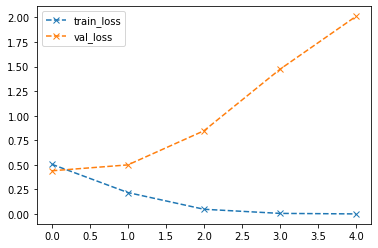

In [25]:
train_losses,val_losses = history 
plt.plot(train_losses,label='train_loss',linestyle='--', marker='x')
plt.plot(val_losses,label='val_loss',linestyle='--',marker='x')
plt.legend()
plt.show()

In [26]:
evaluate(model)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2.0125842094421387

In [27]:
# Prediction on the validation data
for input,target in test_loader:
  input = input.to(device)
  preds = model(input)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
# Checking the accuracy 
preds = preds>0.5
print(classification_report(preds.cpu().detach(),target))

              precision    recall  f1-score   support

       False       0.85      0.80      0.82      3177
        True       0.73      0.79      0.76      2164

    accuracy                           0.79      5341
   macro avg       0.79      0.79      0.79      5341
weighted avg       0.80      0.79      0.79      5341

